<a href="https://colab.research.google.com/github/chanphil2002/fake-news-detection/blob/main/FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

drive.mount('/content/drive')
fake_file_path = '/content/drive/MyDrive/Colab Notebooks/data/Fake.csv'
real_file_path = '/content/drive/MyDrive/Colab Notebooks/data/True.csv'
fake = pd.read_csv(fake_file_path)
real = pd.read_csv(real_file_path)

# Check the first few rows of the dataset
print(fake.head())
print(real.head())

# Add labels: 0 for fake, 1 for real
fake['label'] = 0
real['label'] = 1

# Combine datasets
data = pd.concat([fake, real], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Merge title and text into a single field
data['content'] = data['title'].fillna('') + " " + data['text'].fillna('')
data = data[['content', 'label']]

# Basic overview
print(data.head())
print(data['label'].value_counts())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
           

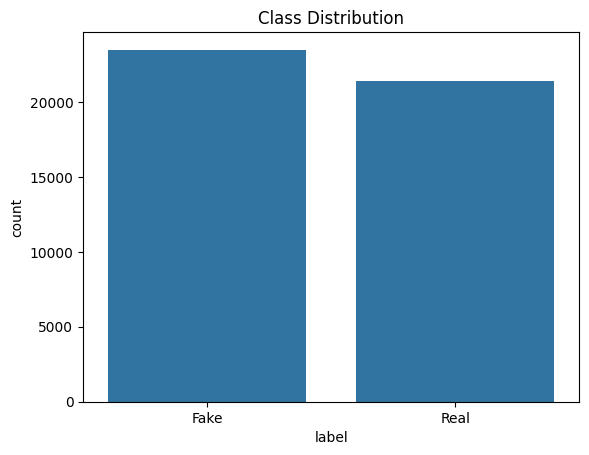

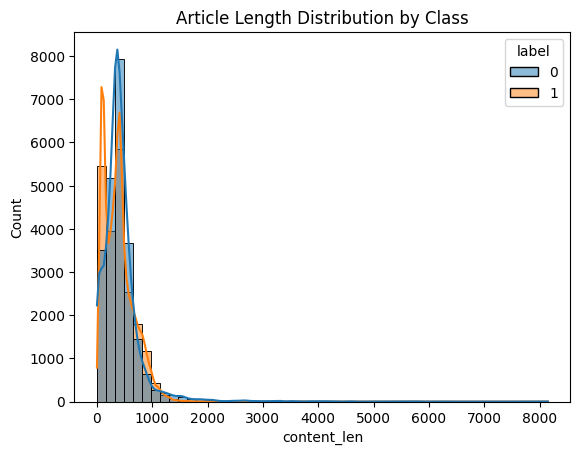

In [ ]:
# Class balance
sns.countplot(data=data, x='label')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.title("Class Distribution")
plt.show()

# Add length feature
data['content_len'] = data['content'].apply(lambda x: len(x.split()))

# Article length by class
sns.histplot(data=data, x='content_len', hue='label', bins=50, kde=True)
plt.title("Article Length Distribution by Class")
plt.show()

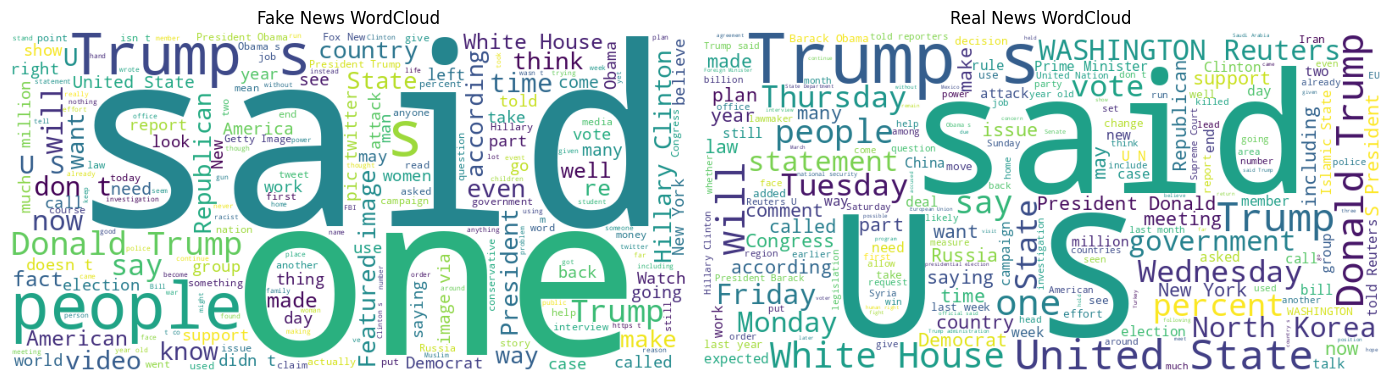

In [ ]:
from wordcloud import WordCloud

fake_text = " ".join(data[data['label']==0]['content'].tolist())
real_text = " ".join(data[data['label']==1]['content'].tolist())

plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(fake_text))
plt.title("Fake News WordCloud")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(real_text))
plt.title("Real News WordCloud")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
!pip install nltk
!pip install keras-tuner

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('english'))

# Text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)           # Remove text in brackets
    text = re.sub(r'http\S+|www\S+', '', text)     # Remove URLs
    text = re.sub(r'<.*?>+', '', text)             # Remove HTML tags
    text = re.sub(r'[^a-z\s]', '', text)           # Remove punctuation/numbers
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

# Apply cleaning
data['clean_content'] = data['content'].apply(clean_text)

# Parameters
MAX_WORDS = 15000
MAX_LEN = 300

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(data['clean_content'])

X = tokenizer.texts_to_sequences(data['clean_content'])
X = pad_sequences(X, maxlen=MAX_LEN)

y = data['label'].values

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional, SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

EMBEDDING_DIM = 128
EPOCHS = 10
BATCH_SIZE = 64

In [ ]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN))
lstm_model.add(SpatialDropout1D(0.3))
lstm_model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train
history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 458s 993ms/step - accuracy: 0.8520 - loss: 0.3160 - val_accuracy: 0.9758 - val_loss: 0.0772
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 491s 972ms/step - accuracy: 0.9757 - loss: 0.0806 - val_accuracy: 0.9802 - val_loss: 0.0676
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 441s 970ms/step - accuracy: 0.9843 - loss: 0.0503 - val_accuracy: 0.9864 - val_loss: 0.0558
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 469s 1s/step - accuracy: 0.9893 - loss: 0.0390 - val_accuracy: 0.9918 - val_loss: 0.0329
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 479s 978ms/step - accuracy: 0.9930 - loss: 0.0261 - val_accuracy: 0.9903 - val_loss: 0.0370
Epoch 6/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 434s 967ms/step - accuracy: 0.9920 - loss: 0.0263 - val_accuracy: 0.9897 - val_loss: 0.0394


In [ ]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(1, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

# Train
history_cnn = cnn_model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 108s 236ms/step - accuracy: 0.9034 - loss: 0.2224 - val_accuracy: 0.9905 - val_loss: 0.0300
Epoch 2/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 236ms/step - accuracy: 0.9926 - loss: 0.0277 - val_accuracy: 0.9925 - val_loss: 0.0236
Epoch 3/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 107s 238ms/step - accuracy: 0.9973 - loss: 0.0096 - val_accuracy: 0.9946 - val_loss: 0.0161
Epoch 4/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 107s 238ms/step - accuracy: 0.9994 - loss: 0.0038 - val_accuracy: 0.9955 - val_loss: 0.0173
Epoch 5/10
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 247ms/step - accuracy: 0.9997 - loss: 0.0015 - val_accuracy: 0.9953 - val_loss: 0.0195


LSTM Test Accuracy: 0.9903
CNN Test Accuracy: 0.9943


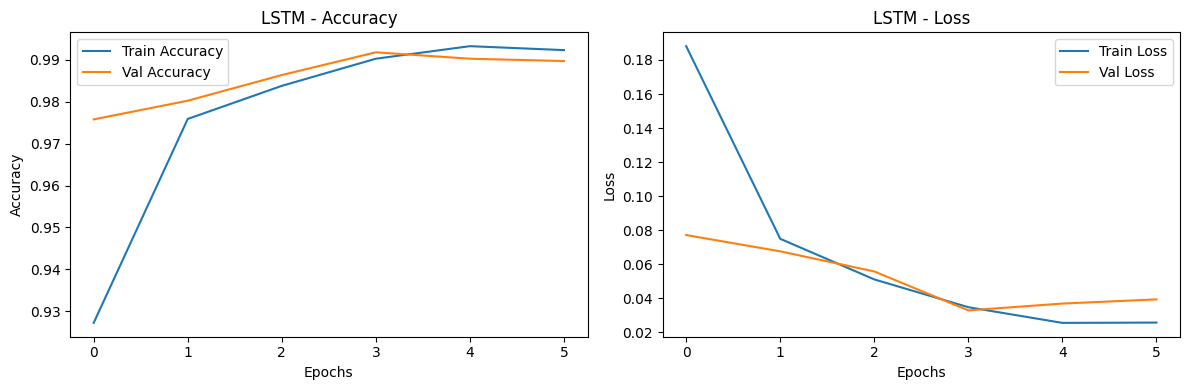

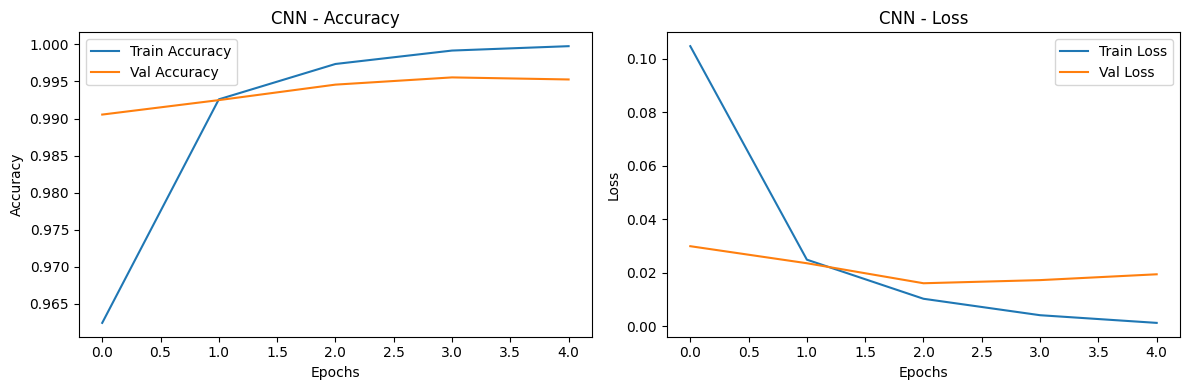

In [ ]:
# Evaluate LSTM
loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM Test Accuracy: {accuracy_lstm:.4f}")

# Evaluate CNN
loss_cnn, accuracy_cnn = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"CNN Test Accuracy: {accuracy_cnn:.4f}")

import matplotlib.pyplot as plt

def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot LSTM
plot_history(history_lstm, 'LSTM')

# Plot CNN
plot_history(history_cnn, 'CNN')
